<a href="https://colab.research.google.com/github/YashVihari/twitter_numerical_data/blob/model/social_influence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
# !wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
# !dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
# !apt-get install -f
# !apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive onto the colab workspace using that directory.

!mkdir -p drive

!google-drive-ocamlfuse drive
!pip install tables
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools


In [0]:
!ls ./drive/Colab\ Notebooks/social/

'Data Science'		  Test_Data_X.csv    Train_Data_y.csv
'Problem Statement.pdf'   Train_Data_X.csv


Using **Google Colaboratory** so the above cells are for mounting **Google Drive** and obtaining the data set paths

In [0]:
import pandas as pd
import numpy as np

train = pd.read_csv('./drive/Colab Notebooks/social/Train_Data_X.csv',index_col=[0])     # Reading the datasets 
labels = pd.read_csv('./drive/Colab Notebooks/social/Train_Data_y.csv',index_col=[0])    
test = pd.read_csv('./drive/Colab Notebooks/social/Test_Data_X.csv',index_col=[0])       

# print(train.head(3))
# print(labels.head(2))
# test_data.head()

In [0]:
print(train.shape)    # Training dataset has 2711 points with 22 features(columns)

(2711, 22)


In [0]:
print(train.isnull().values.any())     #There are no Missing values in dataset

False


In [0]:
train.columns        

Index(['X_follower_count', 'X_following_count', 'X_listed_count',
       'X_mentions_received', 'X_retweets_received', 'X_mentions_sent',
       'X_retweets_sent', 'X_posts', 'X_network_feature_1',
       'X_network_feature_2', 'X_network_feature_3', 'Y_follower_count',
       'Y_following_count', 'Y_listed_count', 'Y_mentions_received',
       'Y_retweets_received', 'Y_mentions_sent', 'Y_retweets_sent', 'Y_posts',
       'Y_network_feature_1', 'Y_network_feature_2', 'Y_network_feature_3'],
      dtype='object')

In [0]:
print(labels.shape)
print(labels.head())

(2711, 1)
   X_social_than_Y?
0                 0
1                 0
2                 1
3                 1
4                 1


In [0]:
labels = np.squeeze(labels)       # squeeze is used to remove the first column that is  not necessary
print(labels.shape)

(2711,)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Standardizing the data
std = StandardScaler()             

xtr = std.fit_transform(train)       #training set
# xvd = std.transform(xvd)           #validation set
ytr = labels


In [0]:
import warnings

# dir(warnings) 
warnings.filterwarnings("ignore")   # To suppresss the Warnings

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline

# These classifiers are the first-go for building a model so chose them  
bnb = BernoulliNB() 
lr = LogisticRegression() 
rfc = RandomForestClassifier()
xgboost = xgb.XGBClassifier()


# Here parameter tuning of multiple classifiers is done under single execution with GridSearch using Pipeline
# Paramtere tuning gives the best model with best parameters 

pipe = Pipeline([('clf',RandomForestClassifier())])           # Placehold Estimator to create Pipeline

search_space = [{'clf' : [BernoulliNB()],                     #Actual Estimators with Hyper-parameters for tuning 
                'clf__alpha':[1e-4,1e-3,1e-2,1e-1,1,10,100] }, 
               
                {'clf' : [LogisticRegression()],
                'clf__C' :[100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001], 
                'clf__penalty': ['l1','l2']},
               
                {'clf' : [RandomForestClassifier()],
                 'clf__n_estimators' : [50,60,70,80,90,100],     
                 'clf__max_depth' : [2,3,4,5,6,7,8,9,10]},           
                
                {'clf' : [xgb.XGBClassifier()],
                 'clf__n_estimators' : [50,60,70,80,90,100],          
                 'clf__max_depth': [2,3,4,5,6,7,8,9,10],          
                 'clf__learning_rate' : [0.1,0.2,0.3,0.4,0.5]}     
                    
                ]


# 10-Fold Cross-validation of data is also done in GridSearch
grid = GridSearchCV(pipe, search_space, cv = 10, scoring='roc_auc', n_jobs=4)

model = grid.fit(xtr,ytr)
# best estimator model is with best fit data is obtained
best_estimator = model.best_estimator_         

print("Best Hyperparams : ", model.best_params_)
print("Best Accuracy : ", model.best_score_*100)



Best Hyperparams :  {'clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100}
Best Accuracy :  86.48006585412864


In [0]:
# Best estimator is XGBoostClassifier with best parameters is obtained

# calculating training probabilities for plotting ROC curve

train_proba = best_estimator.predict_proba(xtr)       


In [0]:
print(train_proba[:10])    

[[0.33624065 0.66375935]
 [0.74136436 0.25863564]
 [0.01562792 0.9843721 ]
 [0.07662469 0.9233753 ]
 [0.06964821 0.9303518 ]
 [0.9579841  0.04201589]
 [0.13456303 0.865437  ]
 [0.63579684 0.36420316]
 [0.0216105  0.9783895 ]
 [0.8139464  0.18605357]]


In [0]:
import matplotlib.pyplot as plt

# user defined function for plotting ROC curve

def _roc_(y_data,probas): 
  
  yvd = y_data
  
  fpr,tpr,threshold = metrics.roc_curve(yvd,probas[:,1])

  auc = metrics.roc_auc_score(yvd,probas[:,1])

  plt.plot(fpr,tpr, label = "auc_ score "+str(auc))

  print("AUC score : ",(auc)*100)

  plt.plot([0,1],[0,1],'k--')

  plt.legend(loc=4)

AUC score :  92.32607760849567


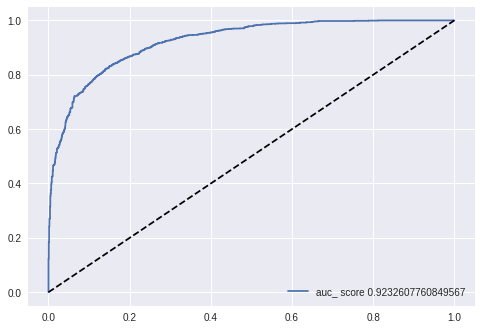

In [0]:
_roc_(ytr,train_proba)

In [0]:
type(best_estimator)

sklearn.pipeline.Pipeline

In [0]:
xg_model = best_estimator.named_steps['clf']  

In [0]:
best_estimator.named_steps['clf'].feature_importances_ 

array([0.08850931, 0.05745342, 0.06677019, 0.02018633, 0.04503106,
       0.02484472, 0.01552795, 0.00621118, 0.03416149, 0.06366459,
       0.04503106, 0.07453416, 0.07608695, 0.12888199, 0.03416149,
       0.02950311, 0.01708074, 0.02018633, 0.03571429, 0.0310559 ,
       0.05279503, 0.0326087 ], dtype=float32)

In [0]:
dir(best_estimator.named_steps['clf'])  

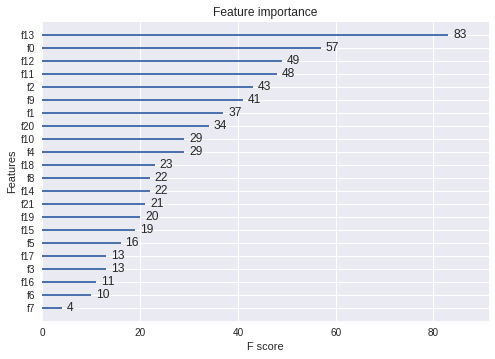

In [0]:
# (best_estimator.feature_importance_)

from xgboost import plot_importance

plot_importance(xg_model)
plt.show()



In [0]:
#  Best model obtained is XGBoost classifier 

#  Using it to predict the results of Test data

# Standardizing the Test data
xtest = std.transform(test)    

# Predicting test data label probabilities using best estimator
predicted_label_probas = best_estimator.predict_proba(xtest)     

print(predicted_label_probas[:10])

[[0.9757816  0.0242184 ]
 [0.66406703 0.33593297]
 [0.28828526 0.71171474]
 [0.8355262  0.16447376]
 [0.938016   0.06198398]
 [0.96204907 0.03795091]
 [0.44914645 0.55085355]
 [0.50285065 0.49714935]
 [0.16905314 0.83094686]
 [0.72784954 0.27215046]]


In [0]:
# Predicting test data labels using Best Estimator 

predicted_labels = best_estimator.predict(xtest)        
print(predicted_labels[:10])



[0 0 1 0 0 0 1 0 1 0]


In [0]:
res = pd.DataFrame(data = predicted_labels, columns=['Predictions']).to_csv('./drive/prediction.csv',index=False)

In [0]:
re = pd.read_csv('./drive/prediction.csv')

In [0]:
# re.head(10)

,Predictions
0,0
1,0
2,1
3,0
4,0
5,0
6,1
7,0
8,1
9,0


In [0]:
!ls ./drive/*.csv -aril

7 -rw-r--r-- 1 root root 2338 Feb 10 09:47 ./drive/prediction.csv
